***
# COVID-19/SARS B-cell Epitope Prediction
A simple dataset for epitope prediction used in vaccine development

Source: https://www.kaggle.com/futurecorporation/epitope-prediction
***

**Introduction**

Due to spread of COVID-19, vaccine development is being demanded as soon as possible. Despite the importance of data analysis in vaccine development, there are not many simple data sets that data analysts can handle. We published the dataset and the sample code for Bcell epitope prediction, one of the key research topics in vaccine development, available for free. This dataset was developed during our research process and the data contained in it was obtained from IEDB and UniProt. We would like to express our deepest gratitude to everyone who helped us. We briefly describe the B-cell epitope predictions covered by this dataset.  For details, please refer to our paper, our blog (only in Japanese), and others. B-cells inducing antigen-specific immune responses in vivo produce large amounts of antigen-specific antibodies by recognizing the subregions (epitope regions) of antigen proteins. They can inhibit their functioning by binding antibodies to antigen proteins. Predicting of epitope regions is beneficial for the design and development of vaccines aimed to induce antigen-specific antibody production. We believe that this dataset and code will be widely useful not only for COVID-19 but also for future medical data analysis.

The data: Information on whether or not an amino acid peptide exhibited antibody-inducing activity (marked by an activity label) could be obtained from IEDB, which was used in many previous studies. Accordingly, this information was used as the label data. We also obtained the epitope candidate amino acid sequences (peptides) and the activity label data from the B-cell epitope data provided in IEDB. The presented antibody proteins were restricted to IgG that constituted the most recorded type in IEDB. For convenience, we excluded records representing different quantitative measures of antibody activity for the same peptide from experiments. The epitope data obtained from IEDB corresponded to the five types of activity: "Positive-High," "Positive-Intermediate," "Positive-Low," "Positive," and "Negative." However, due to the limited number of data elements marked with the "Positive-High," "Positive-Intermediate," and "Positive-Low" labels, we equally considered these labels as "Positive", thereby attributing the task to a binary estimation.

**Content**

This contains three data files:

**input_bcell.csv :** this is our main training data. The number of rows is 14387 for all combinations of 14362 peptides and 757 proteins.

**input_sars.csv :** this is also our main training data. The number of rows is 520.

**input_covid.csv :** this is our target data. there is no label data in columns.</br></br>

***
All of three datasets consists of information of protein and peptide:

**parent_protein_id :** parent protein ID

**protein_seq :** parent protein sequence

**start_position :** start position of peptide

**end_position :** end position of peptide

**peptide_seq :** peptide sequence

**chou_fasman :** peptide feature, β turn

**emini :** peptide feature, relative surface accessibility

**kolaskar_tongaonkar :** peptide feature, antigenicity

**parker :** peptide feature, hydrophobicity

**isoelectric_point :** protein feature

**aromacity:** protein feature

**hydrophobicity :** protein feature

**stability :** protein feature

**target :** antibody valence (target value within the bcell and sars datasets only)

*** 
## Task Descriptions
***

### Task 1

Our purpose is estimating the epitope region of SARS-CoV by only analyzing the B-cell dataset.

We are addressed the problem of classifying peptides into two categories in this task: antibodies with inducing properties (positive) and antibodies without inducing properties (negative), similar to the paper we have published.

Using the data provided, predict the antibody valence of the SARS-CoV data. It has a target value, so you can experiment and train normally to develop a model.</br>


**Evaluation**

**1. Area Under the Curve(AUC)**

AUC of epitope prediction for SARS using the Bcell dataset as the training set and the SARS dataset as the test set.

**2. Documentation Quality**

Reusable and easy-to-understand code

### Task 2

Using the data provided, predict the antibody valence of the SARS-CoV2 data. It does not have a target value, so this is the challenge point of this task.</br>

**Evaluation**

**1. Prediction results for SARS-CoV-2 dataset**</br>

List of epitope predictions for SARS-CoV-2 using the B-cell and SARS datasets as the training set and the SARS-CoV-2 dataset as the test set.

**2. Documentation Quality**</br>

Reusable and easy-to-understand code


***
## Approach
***

**Task 1**</br>

1. Environment setup</br>
2. Exploratory data analysis (EDA)</br>
3. Feature generation (based on peptide length and within-peptide amino acid count)</br>
4. Helper functions</br>
5. Supervised learning models applied to B-cell (training) and SARS-CoV (test) datasets</br>
6. Identify best classifier</br>

**Task 2**</br>

1. Feature generation (based on peptide length and within-peptide amino acid count)</br>
2. Apply optimal model identified in Task 1 to (unlabeled) SARS-CoV2 dataset</br>
3. Generate list of epitope predictions</br>

***
# Import Libraries, Setup Environment
***

In [1]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
#from jupyterthemes import jtplot
#jtplot.style(theme="monokai", context="notebook", ticks=True, grid=False)
import seaborn as sns
sns.set_style('whitegrid')

from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, fbeta_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier

***
# Load Datasets and Perform EDA
***

In [2]:
## Load datasets
bcell = pd.read_csv('input_bcell.csv')
sars = pd.read_csv('input_sars.csv')

In [3]:
## could probably extract more information regarding amino acid 'content' of epitopes
cols = ['G','A','V','L','I','F','M','P','W','C', 'S','T','N','Q','Y','D','E','K', 'R','H']

# bcell data
a = (np.zeros(shape=(bcell.shape[0],len(cols))))
bcell_aa_df = pd.DataFrame(a, columns = cols)

for row, ii in enumerate(list(bcell.peptide_seq)):
    for jj in ii:
        bcell_aa_df.loc[row, jj] = bcell_aa_df.loc[row, jj]+1
        
# sars data
a = (np.zeros(shape=(sars.shape[0],len(cols))))
sars_aa_df = pd.DataFrame(a, columns = cols)

for row, ii in enumerate(list(sars.peptide_seq)):
    for jj in ii:
        sars_aa_df.loc[row, jj] = sars_aa_df.loc[row, jj]+1

In [4]:
bcell = pd.concat([bcell, bcell_aa_df], axis = 1)
sars  = pd.concat([sars, sars_aa_df], axis = 1)

In [5]:
print('bcell matrix size: {}'.format(bcell.shape))
print('sars matrix size: {}'.format(sars.shape))

bcell matrix size: (14387, 34)
sars matrix size: (520, 34)


In [6]:
bcell.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14387 entries, 0 to 14386
Data columns (total 34 columns):
parent_protein_id      14387 non-null object
protein_seq            14387 non-null object
start_position         14387 non-null int64
end_position           14387 non-null int64
peptide_seq            14387 non-null object
chou_fasman            14387 non-null float64
emini                  14387 non-null float64
kolaskar_tongaonkar    14387 non-null float64
parker                 14387 non-null float64
isoelectric_point      14387 non-null float64
aromaticity            14387 non-null float64
hydrophobicity         14387 non-null float64
stability              14387 non-null float64
target                 14387 non-null int64
G                      14387 non-null float64
A                      14387 non-null float64
V                      14387 non-null float64
L                      14387 non-null float64
I                      14387 non-null float64
F                      143

In [7]:
sars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 520 entries, 0 to 519
Data columns (total 34 columns):
parent_protein_id      520 non-null object
protein_seq            520 non-null object
start_position         520 non-null int64
end_position           520 non-null int64
peptide_seq            520 non-null object
chou_fasman            520 non-null float64
emini                  520 non-null float64
kolaskar_tongaonkar    520 non-null float64
parker                 520 non-null float64
isoelectric_point      520 non-null float64
aromaticity            520 non-null float64
hydrophobicity         520 non-null float64
stability              520 non-null float64
target                 520 non-null int64
G                      520 non-null float64
A                      520 non-null float64
V                      520 non-null float64
L                      520 non-null float64
I                      520 non-null float64
F                      520 non-null float64
M                      5

So we have a full complement of non-null data for both the bcell (14387 instances) and sars (520 instances) datasets

This is a binary classification task. We should check to see how balanced the labels are for the bcell and sars datasets. Below, we can see that the datasets are unbalanced, which we should keep in mind throughout.

In [8]:
print('bcell target counts:\n{}\n'.format(bcell['target'].value_counts()))
print('sars target counts:\n{}\n'.format(sars['target'].value_counts()))

bcell target counts:
0    10485
1     3902
Name: target, dtype: int64

sars target counts:
0    380
1    140
Name: target, dtype: int64



In [9]:
bcell.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,...,S,T,N,Q,Y,D,E,K,R,H
0,A2T3T0,MDVLYSLSKTLKDARDKIVEGTLYSNVSDLIQQFNQMIITMNGNEF...,161,165,SASFT,1.016,0.703,1.018,2.22,5.810364,...,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,F0V2I4,MTIHKVAINGFGRIGRLLFRNLLSSQGVQVVAVNDVVDIKVLTHLL...,251,255,LCLKI,0.770,0.179,1.199,-3.86,6.210876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,O75508,MVATCLQVVGFVTSFVGWIGVIVTTSTNDWVVTCGYTIPTCRKLDE...,145,149,AHRET,0.852,3.427,0.960,4.28,8.223938,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0
3,O84462,MTNSISGYQPTVTTSTSSTTSASGASGSLGASSVSTTANATVTQTA...,152,156,SNYDD,1.410,2.548,0.936,6.32,4.237976,...,1.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0
4,P00918,MSHHWGYGKHNGPEHWHKDFPIAKGERQSPVDIDTHTAKYDPSLKP...,85,89,DGTYR,1.214,1.908,0.937,4.64,6.867493,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [10]:
sars.head()

,parent_protein_id,protein_seq,start_position,end_position,peptide_seq,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,...,S,T,N,Q,Y,D,E,K,R,H
0,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,17,MFIFLLFLTLTSGSDLD,0.887,0.040,1.056,-2.159,5.569763,...,2.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
1,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,1,15,MFIFLLFLTLTSGSD,0.869,0.047,1.056,-2.500,5.569763,...,2.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,2,10,FIFLLFLTL,0.621,0.042,1.148,-7.467,5.569763,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,6,20,LFLTLTSGSDLDRCT,1.021,0.230,1.049,0.927,5.569763,...,2.0,3.0,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0
4,AAU93319,MFIFLLFLTLTSGSDLDRCTTFDDVQAPNYTQHTSSMRGVYYPDEI...,9,25,TLTSGSDLDRCTTFDDV,1.089,0.627,1.015,3.165,5.569763,...,2.0,4.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0


## Create New Feature Based on Peptide Length

We are interested in the peptide sequence, but we should utilize numeric data for features. So we will create and add a new feature for peptide length (pep_length) using the start_position and end_position features.


In [11]:
for df in [bcell, sars]:
    df['pep_length'] = df['end_position']-df['start_position']+1
    df['y'] = df['target']

In [12]:
bcell = bcell.drop(columns =['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq', 'target'])
sars  = sars.drop(columns =['parent_protein_id', 'protein_seq', 'start_position', 'end_position', 'peptide_seq', 'target'])

In [13]:
bcell.head()

,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,G,A,...,N,Q,Y,D,E,K,R,H,pep_length,y
0,1.016,0.703,1.018,2.22,5.810364,0.103275,-0.143829,40.273300,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5,1
1,0.770,0.179,1.199,-3.86,6.210876,0.065476,-0.036905,24.998512,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5,1
2,0.852,3.427,0.960,4.28,8.223938,0.091787,0.879227,27.863333,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,5,1
3,1.410,2.548,0.936,6.32,4.237976,0.044776,-0.521393,30.765373,0.0,0.0,...,1.0,0.0,1.0,2.0,0.0,0.0,0.0,0.0,5,1
4,1.214,1.908,0.937,4.64,6.867493,0.103846,-0.578846,21.684615,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,5,1


In [14]:
sars.head()

,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,G,A,...,N,Q,Y,D,E,K,R,H,pep_length,y
0,0.887,0.040,1.056,-2.159,5.569763,0.116335,-0.061116,33.205116,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,17,0
1,0.869,0.047,1.056,-2.500,5.569763,0.116335,-0.061116,33.205116,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,15,0
2,0.621,0.042,1.148,-7.467,5.569763,0.116335,-0.061116,33.205116,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,0
3,1.021,0.230,1.049,0.927,5.569763,0.116335,-0.061116,33.205116,1.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,1.0,0.0,15,0
4,1.089,0.627,1.015,3.165,5.569763,0.116335,-0.061116,33.205116,1.0,0.0,...,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,17,0


## Explore Distributions

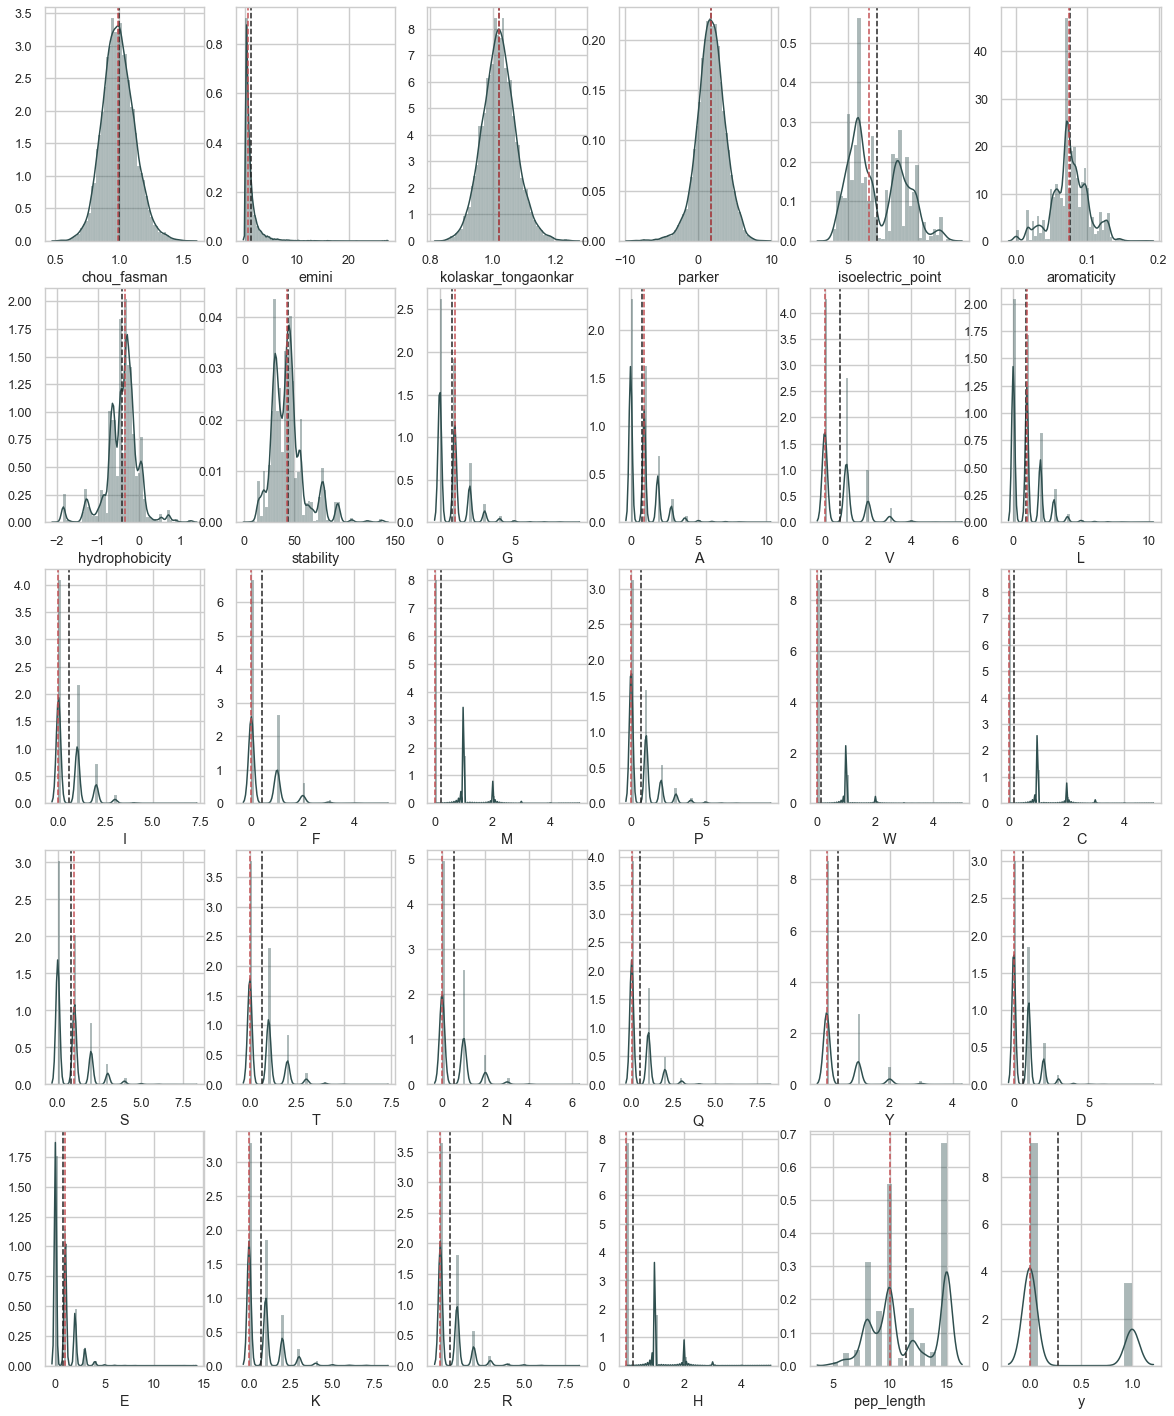

In [15]:
def dist_plotter(data, panel):
    mean = np.mean(data)
    median = np.median(data)
    plt.subplot(5,6,panel)
    sns.distplot(data, color = 'darkslategrey')
    plt.axvline(mean, c = 'k', linestyle = '--')
    plt.axvline(median, c = 'r', linestyle = '--')

fig = plt.figure(figsize=(20,25))
for ii,jj in enumerate(bcell.columns):
    dist_plotter(bcell[jj], ii+1)

In [16]:
bcell_scaled = pd.DataFrame(StandardScaler().fit_transform(bcell),columns = bcell.columns)

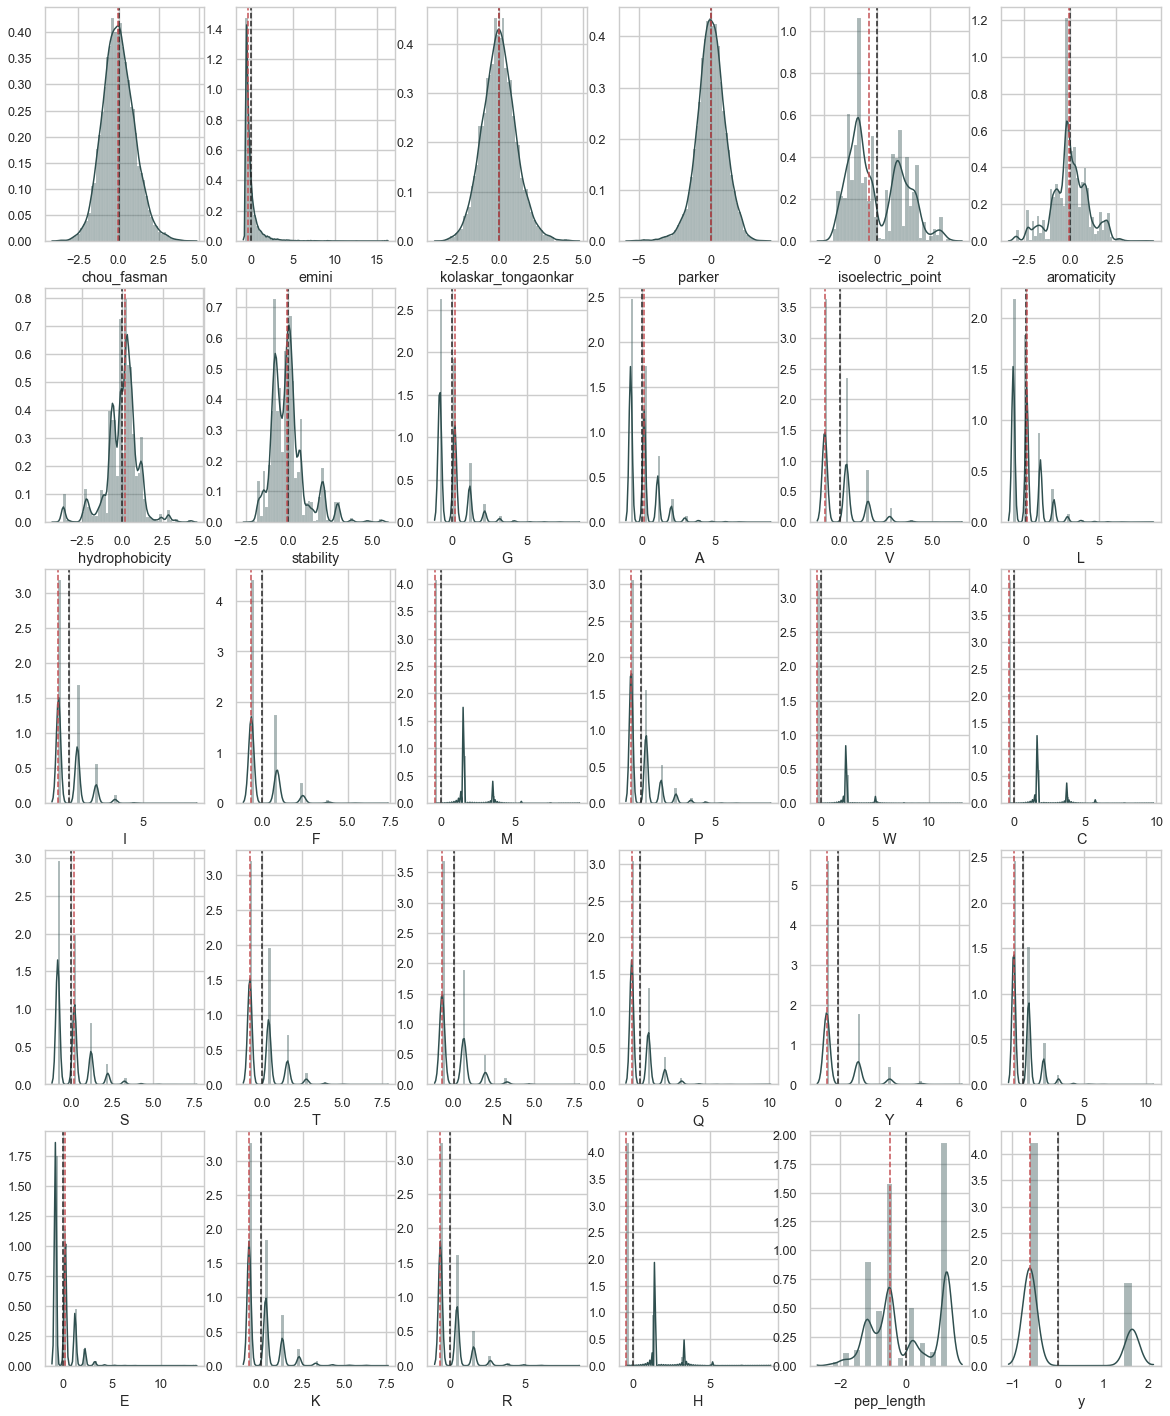

In [17]:
fig = plt.figure(figsize=(20,25))
for ii,jj in enumerate(bcell_scaled.columns):
    dist_plotter(bcell_scaled[jj], ii+1)


## Explore Relationships 


We should investigate the potential relationships between the numeric features and our target variable in our training dataset. The heatmap generated below removes non-useful numeric features based on start and end positions within the protein. At first glance, it appears that isoelectric_point and hydrophobicity show the strongest correlation with the target. In addition, proline (P) count shows the strongest correlation out of all the generated amino acid counts.

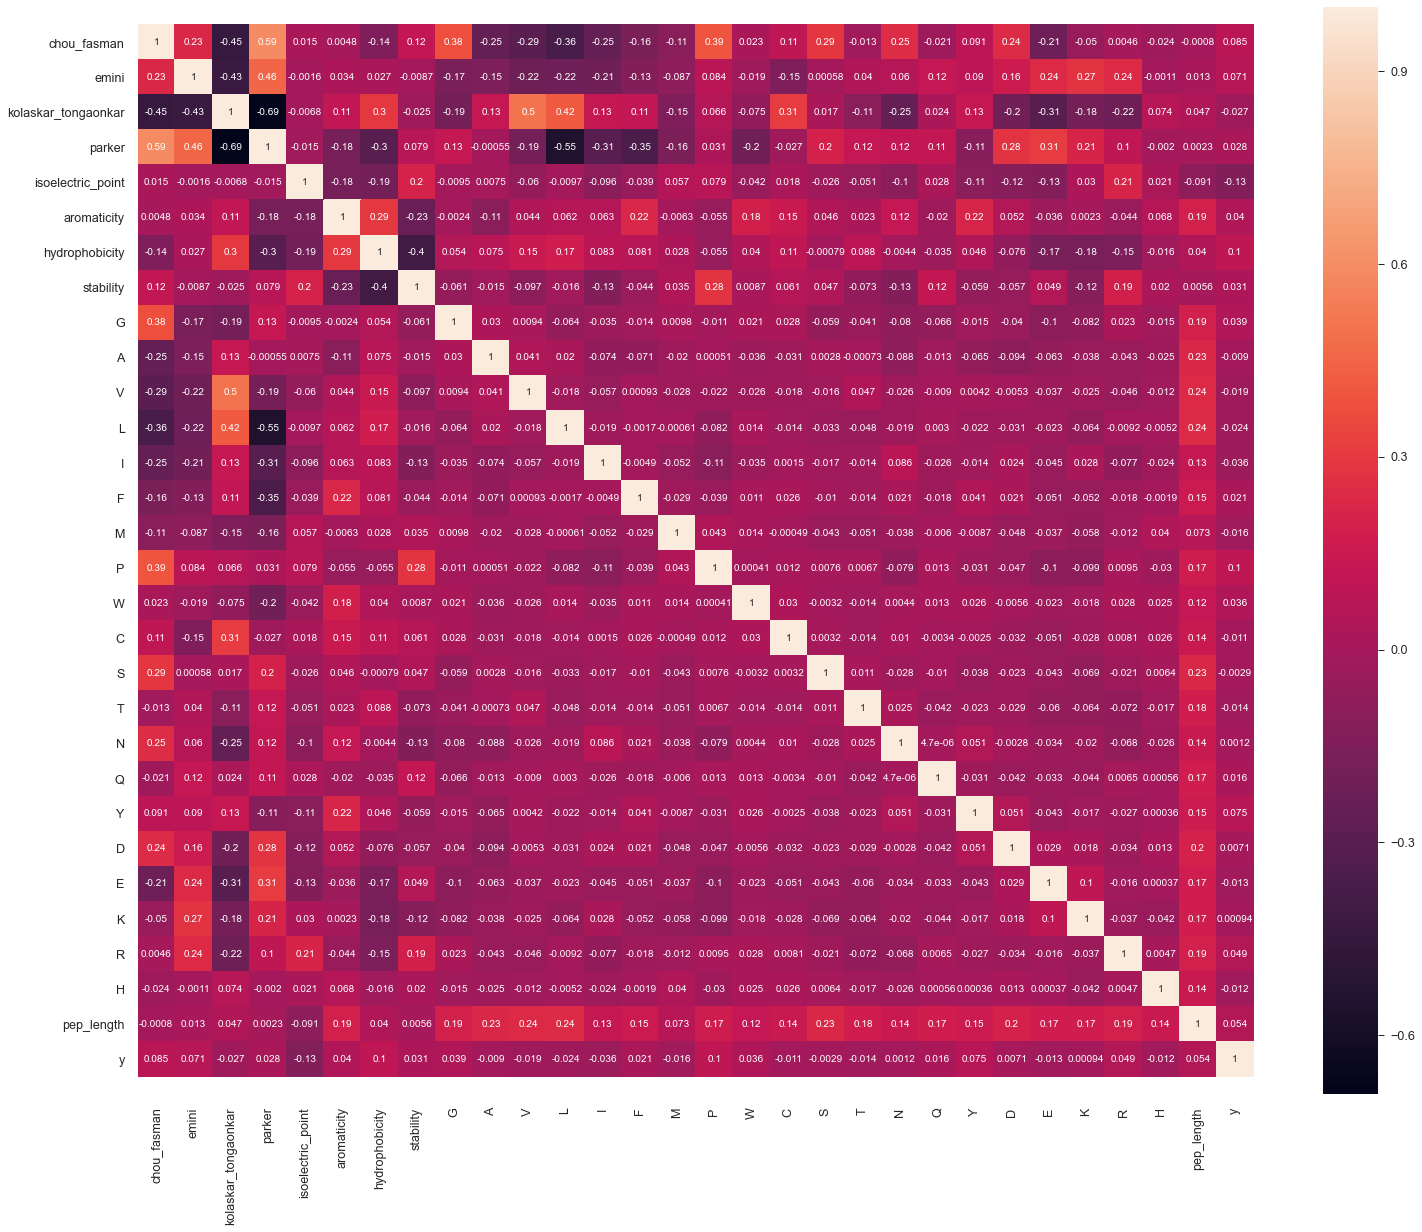

In [18]:
fig = plt.figure(figsize = (25,20))
#sns.heatmap(df.drop(columns = ['start_position', 'end_position']).corr(), annot = True)
sns.heatmap(bcell.corr(), annot = True)

b, t = plt.ylim() # find the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() 

***
# Helper Functions
***

## Confusion Matrix (Seaborn)

In [19]:
def seaborn_cm(data_cm, bin0, bin1, title): # Uses Seaborn's heatmap
    accuracy = np.trace(data_cm)/float(np.sum(data_cm))
    misclass = 1-accuracy
    cm2plot = pd.DataFrame(data_cm.T, columns = [bin0, bin1], index = [bin0, bin1])
    fig = plt.figure(figsize=(8,6))
    sns.heatmap(cm2plot, square = True, annot = True, fmt = "d", linecolor = 'grey', linewidths = 1, cmap = 'YlGnBu')
    plt.ylabel('Predicted Value')
    plt.xlabel('Ground Truth\naccuracy = {:0.4f}; misclass = {:0.4f}'.format(accuracy, misclass))
    plt.title('Confusion Matrix for {} Model'.format(title))
    b, t = plt.ylim() # find the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values

## Validation of TP, TN, FP, FN

In [20]:
def clf_validation(predictions, y_test):
    tn = tp = fn = fp = 0 

    for ii in range(len(predictions)):
        if predictions[ii] == 0 and y_test[ii] == 0:
            tn+=1
        elif predictions[ii] == 0 and y_test[ii] == 1:
            fn+=1
        elif predictions[ii] == 1 and y_test[ii] == 0:
            fp+=1
        elif predictions[ii] == 1 and y_test[ii] == 1:
            tp+=1
    print('TP count: {}'.format(tp))
    print('TN count: {}'.format(tn))
    print('FP count: {}'.format(fp))
    print('FN count: {}'.format(fn))

## Classifier Performance Metrics

In [21]:
def clf_performance_metrics(y_test, predictions): # We'll be using this several times
    print('Accuracy Score: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision Score: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall Score: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1 Score: {:.2f}'.format(f1_score(y_test, predictions)))
    print('Fbeta Score Favoring Precision: {:.2f}'.format(fbeta_score(y_test, predictions, .5)))
    print('Fbeta Score Favoring Recall: {:.2f}'.format(fbeta_score(y_test, predictions, 2)))


##  AUC Plotter

In [22]:
def auc_plotter(fpr, tpr, fpr_proba, tpr_proba, classifier): # We'll be using explicit calculation of auc epitope prediction, but it's nice to visualize
    plt.subplot(1,2,1)
    sns.lineplot(x = fpr, y = tpr, color = 'red')
    plt.fill(fpr, tpr, 'grey', alpha = 0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC curve for {} Model'.format(classifier))
    
    plt.subplot(1,2,2)
    sns.lineplot(x = fpr_proba, y = tpr_proba, color = 'red')
    plt.fill(fpr_proba, tpr_proba, 'grey', alpha = 0.3)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate (1-Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('ROC curve for {} Model (predict_proba)'.format(classifier))
    
    plt.show()

***
# Create Training and Test Data
***

In [23]:
y_train = bcell['y']
y_test = sars['y']
X_train = bcell.drop(columns = ['y'])
X_test = sars.drop(columns = ['y'])

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('y_test shape: {}'.format(y_test.shape))

X_train shape: (14387, 29)
y_train shape: (14387,)
X_test shape: (520, 29)
y_test shape: (520,)


As shown earlier, we have an unbalanced binary classification dataset. We should calculate and keep in mind what a dummy classifier score would look like based on the dominant (0 or 'negative') class.

In [24]:
dummy = DummyClassifier(strategy = 'most_frequent')
dummy.fit(X_train, y_train)
print('Dummy Classifier Score: {:0.3f}'.format(dummy.score(X_test, y_test)))

Dummy Classifier Score: 0.731


***
# Evaluation of Classifiers
***

From scikit learn:</br>

Often the hardest part of solving a machine learning problem can be finding the right estimator for the job.

Different estimators are better suited for different types of data and different problems.

The flowchart below is designed to give users a bit of a rough guide on how to approach problems with regard to which estimators to try on your data.

https://drive.google.com/file/d/1-brT8WN49W6jLoLbotPjreC-z8xxL8YM/view?usp=sharing
    
We will use this flowchart to evaluate several different classifiers as outlined below.

Classifiers to be evaluated:

    6.1 Linear SVC
    6.2 K-neighbors Classifier
    6.3 Random Forest Classifier
    6.4 XGBoost
    6.5 Nonlinear SVM Classifier
    6.6 Multi Layer Perceptron Classifier

***
## Linear Support Vector Classifier
***

### Instantiate model, grid search with cross-validation

Note that, for some of the classifiers under evaluation, we will need to apply scaling to the feature space. This is true for classifiers that operate using distance metrics (e.g. support vector machines, K-nearest neighbors classifiers). So we will create 'X_train_scaled' and 'X_test_scaled' data sets to be used hereafter where applicable.

In [25]:
## Create scaled X_train_scaled and X_test_scaled data
X_train_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train),columns = X_train.columns)
X_test_scaled = pd.DataFrame(StandardScaler().fit_transform(X_test),columns = X_test.columns)

In [26]:
model = 'Linear SVC' # use this string for confusion matric and ROC/AUC plots
lsvc = SVC()

param_grid = {'C':[0.5,1,2], 'kernel':['linear', 'rbf'], 'class_weight': ['balanced']}
grid_search = GridSearchCV(lsvc, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


### Cross-validation with optimal parameters

In [27]:
lsvc = SVC(C = 1, class_weight = 'balanced', kernel = 'linear', verbose = 2, probability = True)
cv_scores = cross_val_score(lsvc, X_train_scaled, y_train, scoring = 'recall', cv = 5, n_jobs=-1)
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.23303457 0.60819462 0.56794872 0.75512821 0.66025641]
Mean cross validation score +/- SD: 0.565 +/- 0.177


### Fit data to model and apply to test dataset

In [28]:
lsvc.fit(X_train_scaled, y_train)
print('Score on test data: {}'.format(lsvc.score(X_test_scaled, y_test)))

[LibSVM]Score on test data: 0.5134615384615384


### Performance metrics, confusion matrix, ROC AUC

In [29]:
# performance metrics
predictions = lsvc.predict(X_test_scaled)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,lsvc.predict(X_test_scaled)))

Accuracy Score: 0.51
Precision Score: 0.32
Recall Score: 0.71
F1 Score: 0.44
Fbeta Score Favoring Precision: 0.36
Fbeta Score Favoring Recall: 0.57

              precision    recall  f1-score   support

           0       0.80      0.44      0.57       380
           1       0.32      0.71      0.44       140

    accuracy                           0.51       520
   macro avg       0.56      0.57      0.50       520
weighted avg       0.67      0.51      0.54       520



TP count: 99
TN count: 168
FP count: 212
FN count: 41


<Figure size 576x432 with 0 Axes>

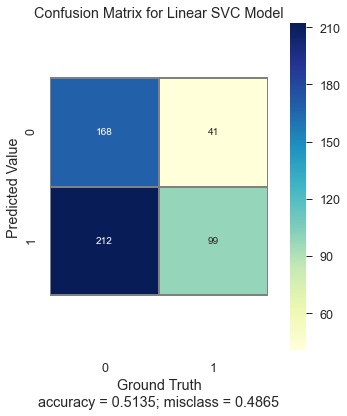

In [30]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

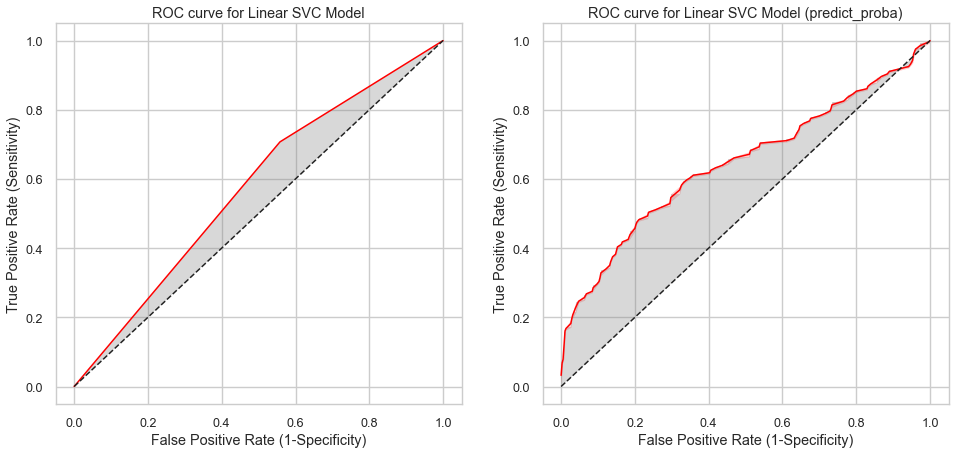

Area under the ROC curve (predict): 0.5746
Area under the ROC curve (predict_proba): 0.6452


In [31]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = lsvc.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = lsvc.predict_proba(X_test_scaled)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

***
## K-Neighbors Classifier
***

### Instantiate model, grid search with cross-validation

In [32]:
model = 'K-Nearest Neighbors' # use this string for confusion matric and ROC/AUC plots
knn = KNeighborsClassifier()

param_grid = {'n_neighbors': [2, 5, 10, 20], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'kd_tree']}
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'algorithm': 'auto', 'n_neighbors': 2, 'weights': 'distance'}


### Cross-validation with optimal parameters

In [33]:
knn = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 2, weights = 'distance')
cv_scores = cross_val_score(knn, X_train_scaled, y_train, scoring = 'recall', cv = 5, n_jobs=-1)
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.28425096 0.29961588 0.36538462 0.39487179 0.35512821]
Mean cross validation score +/- SD: 0.340 +/- 0.042


### Fit data to model and apply to test dataset

In [34]:
knn.fit(X_train_scaled, y_train)
print('Score on test data: {}'.format(knn.score(X_test_scaled, y_test)))

Score on test data: 0.65


### Performance metrics, confusion matrix, ROC AUC

In [35]:
# performance metrics
predictions = knn.predict(X_test_scaled)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,knn.predict(X_test_scaled)))

Accuracy Score: 0.65
Precision Score: 0.35
Recall Score: 0.35
F1 Score: 0.35
Fbeta Score Favoring Precision: 0.35
Fbeta Score Favoring Recall: 0.35

              precision    recall  f1-score   support

           0       0.76      0.76      0.76       380
           1       0.35      0.35      0.35       140

    accuracy                           0.65       520
   macro avg       0.56      0.56      0.56       520
weighted avg       0.65      0.65      0.65       520



TP count: 49
TN count: 289
FP count: 91
FN count: 91


<Figure size 576x432 with 0 Axes>

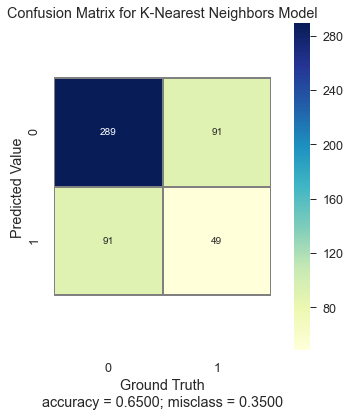

In [36]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

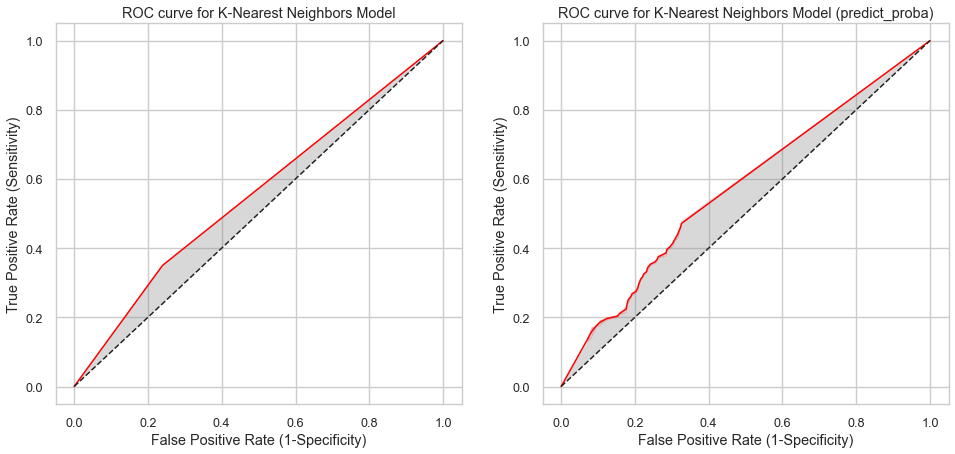

Area under the ROC curve (predict): 0.5553
Area under the ROC curve (predict_proba): 0.5754


In [37]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = knn.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = knn.predict_proba(X_test_scaled)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

***
## Random Forest Classifier
***

### Instantiate model, grid search with cross-validation

In [38]:
model = 'Random Forest Classifier' # use this string for confusion matric and ROC/AUC plots

rfc = RandomForestClassifier()
#param_grid = {'n_estimators': [1, 5, 10], 'max_depth': [5, 10, 15] , 'max_features': [5, 10, 25], 'bootstrap': ['True', 'False']}
param_grid = {'n_estimators': [1000], 'max_depth': [None] , 'n_jobs':[-1], 'max_features': ['sqrt'], 'bootstrap': [True, False], 'criterion':['entropy'], 'min_samples_split':[8]}
grid_search = GridSearchCV(rfc, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 8, 'n_estimators': 1000, 'n_jobs': -1}


### Cross-validation with optimal parameters

In [39]:
rfc = RandomForestClassifier(n_estimators = 1000, max_features = 'sqrt', max_depth = None, bootstrap = False, criterion = 'entropy', min_samples_split = 8, n_jobs = -1)
cv_scores = cross_val_score(rfc, X_train, y_train, cv = 5, n_jobs=-1, scoring = 'recall')
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.67349552 0.19078105 0.59871795 0.43717949 0.35384615]
Mean cross validation score +/- SD: 0.451 +/- 0.172


### Fit data to model and apply to test dataset

In [40]:
rfc.fit(X_train, y_train)
print('Score on test data: {}'.format(rfc.score(X_test, y_test)))

Score on test data: 0.7634615384615384


### Performance metrics, confusion matrix, ROC AUC

In [41]:
# performance metrics
predictions = rfc.predict(X_test)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,rfc.predict(X_test)))

Accuracy Score: 0.76
Precision Score: 0.67
Recall Score: 0.24
F1 Score: 0.35
Fbeta Score Favoring Precision: 0.49
Fbeta Score Favoring Recall: 0.27

              precision    recall  f1-score   support

           0       0.77      0.96      0.86       380
           1       0.67      0.24      0.35       140

    accuracy                           0.76       520
   macro avg       0.72      0.60      0.60       520
weighted avg       0.75      0.76      0.72       520



TP count: 33
TN count: 364
FP count: 16
FN count: 107


<Figure size 576x432 with 0 Axes>

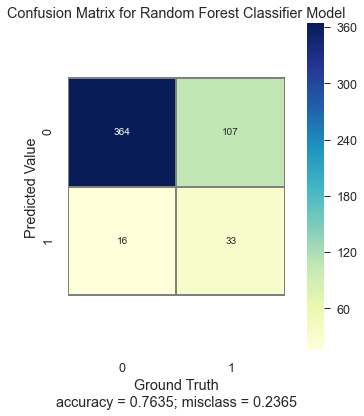

In [42]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

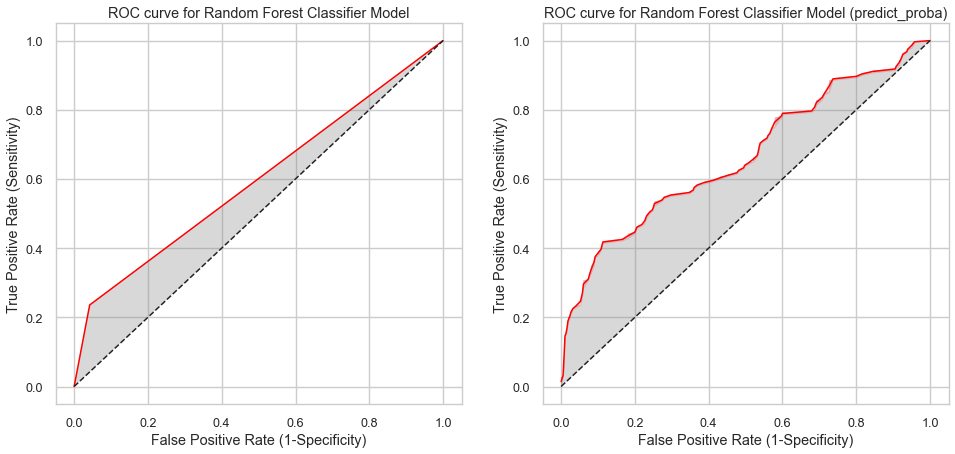

Area under the ROC curve (predict): 0.5968
Area under the ROC curve (predict_proba): 0.6638


In [43]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = rfc.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = rfc.predict_proba(X_test)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

***
## XGBoost Classifier
***

### Instantiate model, grid search with cross-validation

In [44]:
model = 'XGBoost Classifier' # use this string for confusion matric and ROC/AUC plots

xgb = XGBClassifier()
param_grid = {'eta': [0.1, 0.3, 0.5], 'max_depth': [1,6, 12] , 'subsample': [1], 'verbosity': [0], 'scale_pos_weight':[1, 3902/10485] }
grid_search = GridSearchCV(xgb, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1)
grid_search.fit(X_train, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

C:\Users\AndyPC\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Best parameters: {'eta': 0.5, 'max_depth': 6, 'scale_pos_weight': 1, 'subsample': 1, 'verbosity': 0}


### Cross-validation with optimal parameters

In [45]:
xgb = XGBClassifier(eta = 0.5, max_depth = 6, subsample = 1, verbosity = 0, scale_pos_weight = 1)
cv_scores = cross_val_score(xgb, X_train, y_train, cv = 5, n_jobs=-1, scoring = 'recall')
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.58642766 0.22663252 0.65512821 0.48717949 0.36410256]
Mean cross validation score +/- SD: 0.464 +/- 0.154


### Fit data to model and apply to test dataset

In [46]:
xgb.fit(X_train, y_train)
print('Score on test data: {}'.format(xgb.score(X_test, y_test)))

Score on test data: 0.7557692307692307


### Performance metrics, confusion matrix, ROC AUC

In [47]:
# performance metrics
predictions = xgb.predict(X_test)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,xgb.predict(X_test)))

Accuracy Score: 0.76
Precision Score: 0.58
Recall Score: 0.34
F1 Score: 0.43
Fbeta Score Favoring Precision: 0.51
Fbeta Score Favoring Recall: 0.37

              precision    recall  f1-score   support

           0       0.79      0.91      0.84       380
           1       0.58      0.34      0.43       140

    accuracy                           0.76       520
   macro avg       0.68      0.62      0.64       520
weighted avg       0.73      0.76      0.73       520



TP count: 47
TN count: 346
FP count: 34
FN count: 93


<Figure size 576x432 with 0 Axes>

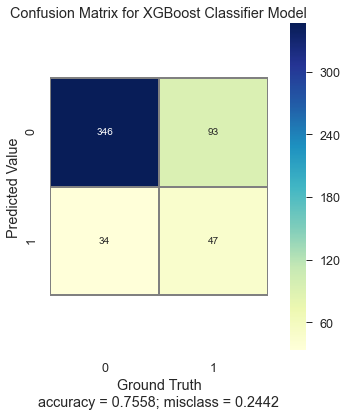

In [48]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

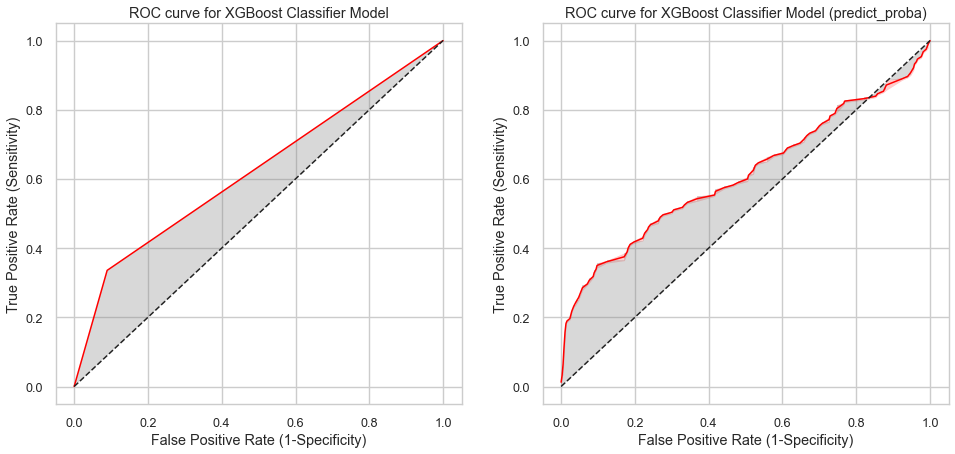

Area under the ROC curve (predict): 0.6231
Area under the ROC curve (predict_proba): 0.6126


In [49]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = xgb.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = xgb.predict_proba(X_test)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

In [50]:
feature_importance = xgb.feature_importances_

Text(0.5, 1.0, 'Feature Importance')

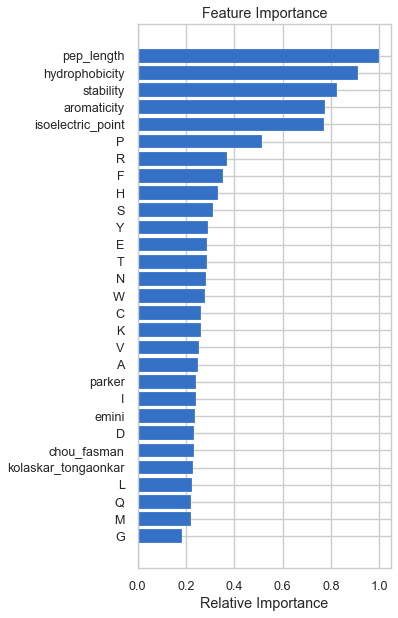

In [51]:
feature_importance = (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(10,10))
plt.subplot(122)
plt.barh(pos, feature_importance[sorted_idx], align = 'center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance')

***
## Nonlinear Support Vector Classifier
***

### Instantiate model, grid search with cross-validation

In [52]:
model = 'Nonlinear SVC' # use this string for confusion matric and ROC/AUC plots

svc = SVC()
param_grid = {'kernel': ['rbf', 'poly'], 'C': [1000,10000] , 'gamma': ['scale']}
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1, verbose = 4)
grid_search.fit(X_train_scaled, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

Fitting 5 folds for each of 2 candidates, totalling 10 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   4 out of  10 | elapsed:   52.6s remaining:  1.3min
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:   57.1s remaining:   24.4s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  1.3min finished


Best parameters: {'C': 10000, 'gamma': 'scale', 'kernel': 'rbf'}


### Cross-validation with optimal parameters

In [53]:
svc = SVC(C = 10000, gamma = 'scale', kernel = 'rbf', probability = True)
cv_scores = cross_val_score(svc, X_train_scaled, y_train, cv = 5, n_jobs=-1, scoring = 'recall')
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.33802817 0.43149808 0.4        0.42435897 0.40512821]
Mean cross validation score +/- SD: 0.400 +/- 0.033


### Fit data to model and apply to test dataset

In [54]:
svc.fit(X_train_scaled, y_train)
print('Score on test data: {}'.format(svc.score(X_test_scaled, y_test)))

Score on test data: 0.49423076923076925


### Performance metrics, confusion matrix, ROC AUC

In [55]:
# performance metrics
predictions = svc.predict(X_test_scaled)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,svc.predict(X_test_scaled)))

Accuracy Score: 0.49
Precision Score: 0.26
Recall Score: 0.46
F1 Score: 0.33
Fbeta Score Favoring Precision: 0.28
Fbeta Score Favoring Recall: 0.40

              precision    recall  f1-score   support

           0       0.72      0.51      0.59       380
           1       0.26      0.46      0.33       140

    accuracy                           0.49       520
   macro avg       0.49      0.48      0.46       520
weighted avg       0.59      0.49      0.52       520



TP count: 65
TN count: 192
FP count: 188
FN count: 75


<Figure size 576x432 with 0 Axes>

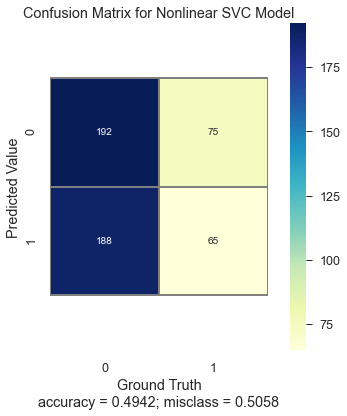

In [56]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

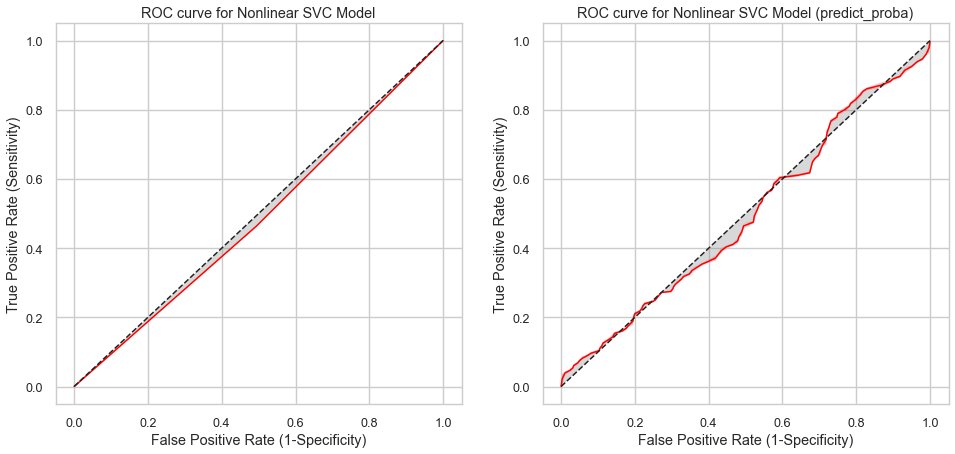

Area under the ROC curve (predict): 0.4848
Area under the ROC curve (predict_proba): 0.4928


In [57]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = svc.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = svc.predict_proba(X_test_scaled)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

***
## Multi-Layer Perceptron Classifier
***

### Instantiate model, grid search with cross-validation

In [58]:
model = 'Multi-Layer Perceptron' # use this string for confusion matric and ROC/AUC plots

mlp = MLPClassifier()

param_grid = {'random_state': [123], 'max_iter': [1000], 'hidden_layer_sizes':[(150,100,50), (300,150,75)]}
grid_search = GridSearchCV(mlp, param_grid, cv=5, scoring = 'recall', return_train_score = True, n_jobs=-1)
grid_search.fit(X_train_scaled, y_train)
print('Best parameters: {}'.format(grid_search.best_params_))

Best parameters: {'hidden_layer_sizes': (300, 150, 75), 'max_iter': 1000, 'random_state': 123}


### Cross-validation with optimal parameters

In [59]:
mlp = MLPClassifier(random_state = 123, max_iter = 1000, hidden_layer_sizes = (300,150,75))
cv_scores = cross_val_score(mlp, X_train_scaled, y_train, cv = 5, n_jobs=-1, scoring = 'recall')
print('Accuracy scores for the 5 folds: {}'.format(cv_scores))
print('Mean cross validation score +/- SD: {:.3f} +/- {:.3f}'.format(np.mean(cv_scores), np.std(cv_scores)))

Accuracy scores for the 5 folds: [0.33290653 0.40717029 0.40128205 0.38589744 0.33589744]
Mean cross validation score +/- SD: 0.373 +/- 0.032


### Fit data to model and apply to test dataset

In [60]:
mlp.fit(X_train_scaled, y_train)
print('Score on test data: {}'.format(mlp.score(X_test_scaled, y_test)))

Score on test data: 0.5788461538461539


### Performance metrics, confusion matrix, ROC AUC

In [61]:
# performance metrics
predictions = mlp.predict(X_test_scaled)
clf_performance_metrics(y_test, predictions)
print('\n'+classification_report(y_test,mlp.predict(X_test_scaled)))

Accuracy Score: 0.58
Precision Score: 0.31
Recall Score: 0.46
F1 Score: 0.37
Fbeta Score Favoring Precision: 0.33
Fbeta Score Favoring Recall: 0.42

              precision    recall  f1-score   support

           0       0.76      0.62      0.68       380
           1       0.31      0.46      0.37       140

    accuracy                           0.58       520
   macro avg       0.53      0.54      0.53       520
weighted avg       0.64      0.58      0.60       520



TP count: 64
TN count: 237
FP count: 143
FN count: 76


<Figure size 576x432 with 0 Axes>

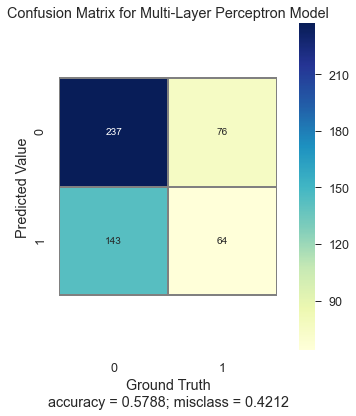

In [62]:
# confusion matrix presentation
confusion = confusion_matrix(y_test, predictions)
fig1 = plt.figure(figsize=(8,6));
seaborn_cm(confusion, 0,1, model)

# call helper function that explicitly calculates tp,tn,fp,fn (verifies output of confusion matrix presentation)
clf_validation(predictions, y_test)

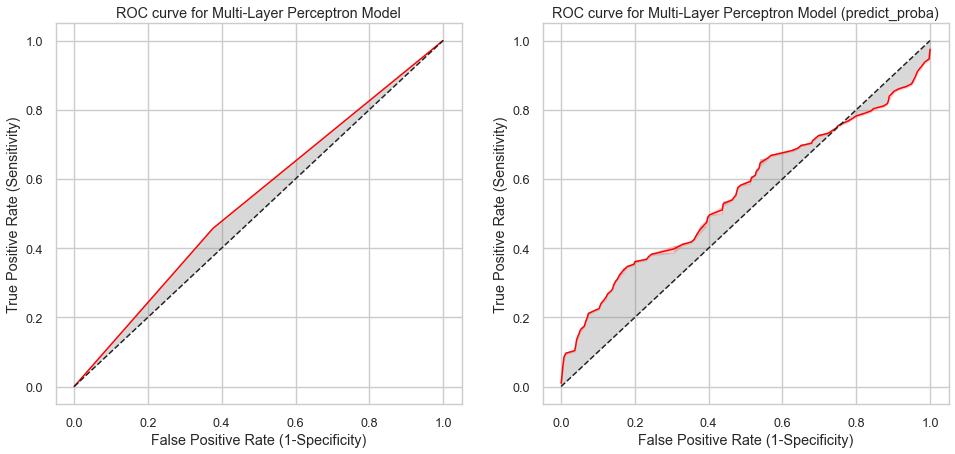

Area under the ROC curve (predict): 0.5404
Area under the ROC curve (predict_proba): 0.5578


In [63]:
# AUC plotting. Two plots, and two calculations provided based on model.predict, and model.predict_proba
fig2 = plt.figure(figsize=(16,7));

probs = mlp.predict(X_test_scaled)
fpr, tpr, thresholds = roc_curve(y_test, probs)
auc = roc_auc_score(y_test, probs)

probs_proba = mlp.predict_proba(X_test_scaled)[:,1]
fpr_proba, tpr_proba, thresholds = roc_curve(y_test, probs_proba)
auc_proba = roc_auc_score(y_test, probs_proba)

auc_plotter(fpr, tpr, fpr_proba, tpr_proba, model)

print('Area under the ROC curve (predict): {:.4f}'.format(auc))
print('Area under the ROC curve (predict_proba): {:.4f}'.format(auc_proba))

***
## Task 1: Conclusions
***

Summary of results (AUC based on *predict_proba*)</br></br>

|Model|AUC|Accuracy|Recall (+ve)|
|:-|:-:|:-:|:-:|
|Linear SVC     |0.65     |0.51     |0.71     |
|KNN            |0.58     |0.65     |0.35     |
|Random Forest  |0.66     |0.76     |0.24     |
|XGBoost        |0.61     |0.76     |0.34     |
|Nonlinear SVC  |0.49     |0.49     |0.46     |
|MLP CLassifier |0.56     |0.58     |0.46     |

* Based on Kaggle criteria, the random forest model achieved the highest AUC (0.66). However, the recall for the positive class (0.24) was actually the lowest of all 6 models under evaluation.
* The linear SVC model showed a comparable AUC (0.65) but also showed highest recall for the positive class (0.71)
* Predicting antibody valence in terms of maximizing positive class predictions will have most impact for vaccine development.
* The linear SVC model should be employed for task 2

Other points of interest:</br>

* Presence of proline (P) could be a critical factor for vaccine development.
* This is evident in the correlation analysis (association between P and target), as well as relative feature importance outputted by the gradient boosting model (XGBoost)
* Following application of the linear SVC to the SARS-CoV2 dataset (task 2), it will be of interest to note the presence/count of phenylalanine in the list of epitope predictions

***
# Task 2
***

Load covid dataset, evaluate missingness

In [26]:
covid = pd.read_csv('input_covid.csv')
covid.shape

(20312, 13)

In [27]:
covid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20312 entries, 0 to 20311
Data columns (total 13 columns):
parent_protein_id      20312 non-null object
protein_seq            20312 non-null object
start_position         20312 non-null int64
end_position           20312 non-null int64
peptide_seq            20312 non-null object
chou_fasman            20312 non-null float64
emini                  20312 non-null float64
kolaskar_tongaonkar    20312 non-null float64
parker                 20312 non-null float64
isoelectric_point      20312 non-null float64
aromaticity            20312 non-null float64
hydrophobicity         20312 non-null float64
stability              20312 non-null float64
dtypes: float64(8), int64(2), object(3)
memory usage: 2.0+ MB


There are 20312 non-null instances for all 13 attributes. We can move on to feature generation as was performed for the b-cell and sars datasets

***
## Train Linear SVC Based on B-Cell and SARS Data
***

Note that Task 2 explicitly states that the b-cell and sars datasets should be used as training data, and the SARS-CoV2 as the test set. We will concatenate the scaled b-cell and SARS-CoV data and retrain the linear SVC model based on the hyperparameters determined in Task 1 (section 6.1.1).

In [28]:
X_train_task2 = pd.concat([X_train_scaled, X_test_scaled], axis = 0)
print(X_train_task2.shape)

y_train_task2 = pd.concat([y_train, y_test], axis = 0)
print(y_train_task2.shape)

(14907, 29)
(14907,)


In [29]:
lsvc_task2 = SVC(C = 1, class_weight = 'balanced', kernel = 'linear', verbose = 2, probability = True)
lsvc_task2.fit(X_train_task2, y_train_task2)

[LibSVM]

SVC(C=1, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=2)

***
## Feature Generation
***

* Add amino acid count to test (covid) data
* Add peptide length to test (covid) data

In [30]:
## could probably extract more information regarding amino acid 'content' of epitopes
cols = ['G','A','V','L','I','F','M','P','W','C', 'S','T','N','Q','Y','D','E','K', 'R','H']

# covid data
a = (np.zeros(shape=(covid.shape[0],len(cols))))
covid_aa_df = pd.DataFrame(a, columns = cols)

for row, ii in enumerate(list(covid.peptide_seq)):
    for jj in ii:
        covid_aa_df.loc[row, jj] = covid_aa_df.loc[row, jj]+1

covid = pd.concat([covid, covid_aa_df], axis = 1)

In [31]:
# add peptide length column data
for df in [covid]:
    df['pep_length'] = df['end_position']-df['start_position']+1

***
## Scale COVID data  
***

In [32]:
## Utilize same columns as used for sars and bcell datasets, scale data ready for linear SVC model
X_covid = covid[list(X_train_scaled.columns)]
X_covid_scaled = pd.DataFrame(StandardScaler().fit_transform(X_covid),columns = X_covid.columns)

In [33]:
X_covid_scaled.head()

,chou_fasman,emini,kolaskar_tongaonkar,parker,isoelectric_point,aromaticity,hydrophobicity,stability,G,A,...,T,N,Q,Y,D,E,K,R,H,pep_length
0,-0.518455,-0.559068,-0.091195,-2.634134,0.0,1.0,-1.0,-1.0,0.102447,-0.797777,...,-0.94136,-0.914658,-0.802788,-0.736206,-0.770397,-0.758068,-0.721298,-0.67324,-0.325366,-1.623358
1,1.044805,-0.482196,0.701509,-1.243913,0.0,1.0,-1.0,-1.0,0.102447,-0.797777,...,-0.94136,-0.914658,-0.802788,-0.736206,-0.770397,-0.758068,-0.721298,-0.67324,-0.325366,-1.623358
2,0.969467,-0.316804,1.515638,-1.711651,0.0,1.0,-1.0,-1.0,-0.925164,-0.797777,...,-0.94136,-0.914658,-0.802788,-0.736206,-0.770397,-0.758068,-0.721298,-0.67324,-0.325366,-1.623358
3,3.022422,-0.127341,0.337294,0.068351,0.0,1.0,-1.0,-1.0,0.102447,-0.797777,...,-0.94136,-0.914658,-0.802788,-0.736206,-0.770397,-0.758068,-0.721298,-0.67324,-0.325366,-1.623358
4,3.041257,0.003109,-1.483784,0.717987,0.0,1.0,-1.0,-1.0,0.102447,-0.797777,...,-0.94136,-0.914658,-0.802788,-0.736206,-0.770397,-0.758068,-0.721298,-0.67324,-0.325366,-1.623358


***
## Linear SVC Prediction
***

In [34]:
predictions = lsvc_task2.predict(X_covid_scaled)
bincounts = np.bincount(predictions)
print('0 class count: {}\n1 class count: {}'.format(bincounts[0],bincounts[1]))

0 class count: 17431
1 class count: 2881


Generate the list of epitopes based on +ve predictions. We also will also keep a track of presence of phenylalanine (P) and methionine (M) within each epitope.

In [35]:
covid_epitopes = []
epitope_length = []
proline_count = []
methionine_count = [] # an amino acid with relatively low feature importance
for ii,jj in enumerate(predictions):
    if jj==1:
        covid_epitopes.append(covid.loc[ii,'peptide_seq'])
        epitope_length.append(len(covid.loc[ii,'peptide_seq']))
        print(covid.loc[ii,'peptide_seq'])      
        proline_count.append(covid.loc[ii,'peptide_seq'].count('P')) 
        methionine_count.append(covid.loc[ii,'peptide_seq'].count('M'))

PDPSK
DPSKP
PSKPS
KPSKR
PSKRS
GYQPYR
PDPSKP
DPSKPS
PSKPSK
SKPSKR
KPSKRS
RGVYYPD
VGYQPYR
GYQPYRV
LPDPSKP
PDPSKPS
DPSKPSK
PSKPSKR
SKPSKRS
PEAPRDG
PRDGQAY
TRGVYYPD
RGVYYPDK
YYPDKVFR
GNYNYLYR
GVGYQPYR
LPDPSKPS
PDPSKPSK
DPSKPSKR
PSKPSKRS
SKPSKRSF
PEAPRDGQ
APRDGQAY
TRGVYYPDK
RGVYYPDKV
YYPDKVFRS
YYVGYLQPR
SVYAWNRKR
GGNYNYLYR
NGVGYQPYR
GVGYQPYRV
LPDPSKPSK
PDPSKPSKR
DPSKPSKRS
PSKPSKRSF
SGYIPEAPR
GYIPEAPRD
YIPEAPRDG
PEAPRDGQA
EAPRDGQAY
PRDGQAYVR
RDGQAYVRK
NSFTRGVYYP
SFTRGVYYPD
FTRGVYYPDK
TRGVYYPDKV
RGVYYPDKVF
GVYYPDKVFR
VYYPDKVFRS
YYPDKVFRSS
AYYVGYLQPR
YYVGYLQPRT
ASVYAWNRKR
YAWNRKRISN
VGGNYNYLYR
GGNYNYLYRL
NYNYLYRLFR
YNYLYRLFRK
NYLYRLFRKS
YLYRLFRKSN
YRLFRKSNLK
RLFRKSNLKP
RKSNLKPFER
PTNGVGYQPY
TNGVGYQPYR
NGVGYQPYRV
YKTPPIKDFG
ILPDPSKPSK
LPDPSKPSKR
PDPSKPSKRS
DPSKPSKRSF
PSKPSKRSFI
KRVDFCGKGY
DGKAHFPREG
YEQYIKGSGR
YFQGGGGSGY
GSGYIPEAPR
SGYIPEAPRD
GYIPEAPRDG
YIPEAPRDGQ
PEAPRDGQAY
APRDGQAYVR
PRDGQAYVRK
RDGQAYVRKD
DGQAYVRKDG
GQAYVRKDGE
PPAYTNSFTRG
NSFTRGVYYPD
SFTRGVYYPDK
FTRGVYYPDKV
TRGVYYPDKVF
RGVYYP

QGNFKNLREFVFKNIDG
GNFKNLREFVFKNIDGY
NFKNLREFVFKNIDGYF
FKNLREFVFKNIDGYFK
KNLREFVFKNIDGYFKI
NLREFVFKNIDGYFKIY
LREFVFKNIDGYFKIYS
REFVFKNIDGYFKIYSK
EFVFKNIDGYFKIYSKH
FVFKNIDGYFKIYSKHT
VFKNIDGYFKIYSKHTP
FKNIDGYFKIYSKHTPI
KNIDGYFKIYSKHTPIN
NIDGYFKIYSKHTPINL
DGYFKIYSKHTPINLVR
GYFKIYSKHTPINLVRD
YFKIYSKHTPINLVRDL
FKIYSKHTPINLVRDLP
KIYSKHTPINLVRDLPQ
IYSKHTPINLVRDLPQG
YSKHTPINLVRDLPQGF
SKHTPINLVRDLPQGFS
KHTPINLVRDLPQGFSA
PINLVRDLPQGFSALEP
RDLPQGFSALEPLVDLP
TRFQTLLALHRSYLTPG
RFQTLLALHRSYLTPGD
LALHRSYLTPGDSSSGW
ALHRSYLTPGDSSSGWT
LHRSYLTPGDSSSGWTA
HRSYLTPGDSSSGWTAG
RSYLTPGDSSSGWTAGA
TPGDSSSGWTAGAAAYY
PGDSSSGWTAGAAAYYV
DSSSGWTAGAAAYYVGY
SSSGWTAGAAAYYVGYL
SSGWTAGAAAYYVGYLQ
SGWTAGAAAYYVGYLQP
GWTAGAAAYYVGYLQPR
WTAGAAAYYVGYLQPRT
TAGAAAYYVGYLQPRTF
AGAAAYYVGYLQPRTFL
GAAAYYVGYLQPRTFLL
AAAYYVGYLQPRTFLLK
AAYYVGYLQPRTFLLKY
AYYVGYLQPRTFLLKYN
YYVGYLQPRTFLLKYNE
YVGYLQPRTFLLKYNEN
VGYLQPRTFLLKYNENG
GYLQPRTFLLKYNENGT
YLQPRTFLLKYNENGTI
QPRTFLLKYNENGTITD
PRTFLLKYNENGTITDA
FTVEKGIYQTSNFRVQP
VEKGIYQTSNFRVQPTE
EKGIYQTSNF

ILPDPSKPSKRSFIEDLLF
LPDPSKPSKRSFIEDLLFN
PDPSKPSKRSFIEDLLFNK
DPSKPSKRSFIEDLLFNKV
PSKPSKRSFIEDLLFNKVT
SKPSKRSFIEDLLFNKVTL
KPSKRSFIEDLLFNKVTLA
DAGFIKQYGDCLGDIAARD
WTFGAGAALQIPFAMQMAY
TFGAGAALQIPFAMQMAYR
FGAGAALQIPFAMQMAYRF
GAGAALQIPFAMQMAYRFN
AGAALQIPFAMQMAYRFNG
GAALQIPFAMQMAYRFNGI
AALQIPFAMQMAYRFNGIG
ALQIPFAMQMAYRFNGIGV
LQIPFAMQMAYRFNGIGVT
QIPFAMQMAYRFNGIGVTQ
IPFAMQMAYRFNGIGVTQN
PFAMQMAYRFNGIGVTQNV
AMQMAYRFNGIGVTQNVLY
MQMAYRFNGIGVTQNVLYE
QMAYRFNGIGVTQNVLYEN
MAYRFNGIGVTQNVLYENQ
AYRFNGIGVTQNVLYENQK
YRFNGIGVTQNVLYENQKL
LNDILSRLDPPEAEVQIDR
NDILSRLDPPEAEVQIDRL
DILSRLDPPEAEVQIDRLI
ILSRLDPPEAEVQIDRLIT
LSRLDPPEAEVQIDRLITG
SRLDPPEAEVQIDRLITGR
RLDPPEAEVQIDRLITGRL
LDPPEAEVQIDRLITGRLQ
DPPEAEVQIDRLITGRLQS
PPEAEVQIDRLITGRLQSL
IRAAEIRASANLAATKMSE
KMSECVLGQSKRVDFCGKG
MSECVLGQSKRVDFCGKGY
SECVLGQSKRVDFCGKGYH
VLGQSKRVDFCGKGYHLMS
LGQSKRVDFCGKGYHLMSF
GQSKRVDFCGKGYHLMSFP
QSKRVDFCGKGYHLMSFPQ
SKRVDFCGKGYHLMSFPQS
KRVDFCGKGYHLMSFPQSA
RVDFCGKGYHLMSFPQSAP
VDFCGKGYHLMSFPQSAPH
DFCGKGYHLMSFPQSAPHG
FCGKGYHLMSFPQSAPHGV


In [36]:
print('Out of {} predicted epitopes, {} contain proline ({:.1f}%)'.format(bincounts[1], 
                                                                            len(proline_count)-proline_count.count(0), 
                                                                            100*(len(proline_count)-proline_count.count(0))/len(proline_count)))

print('Out of {} predicted epitopes, {} contain methionine ({:.1f}%)'.format(bincounts[1], 
                                                                            len(methionine_count)-methionine_count.count(0), 
                                                                            100*(len(methionine_count)-methionine_count.count(0))/len(methionine_count)))

Out of 2881 predicted epitopes, 2145 contain proline (74.5%)
Out of 2881 predicted epitopes, 284 contain methionine (9.9%)


Text(0.5, 0, 'Count')

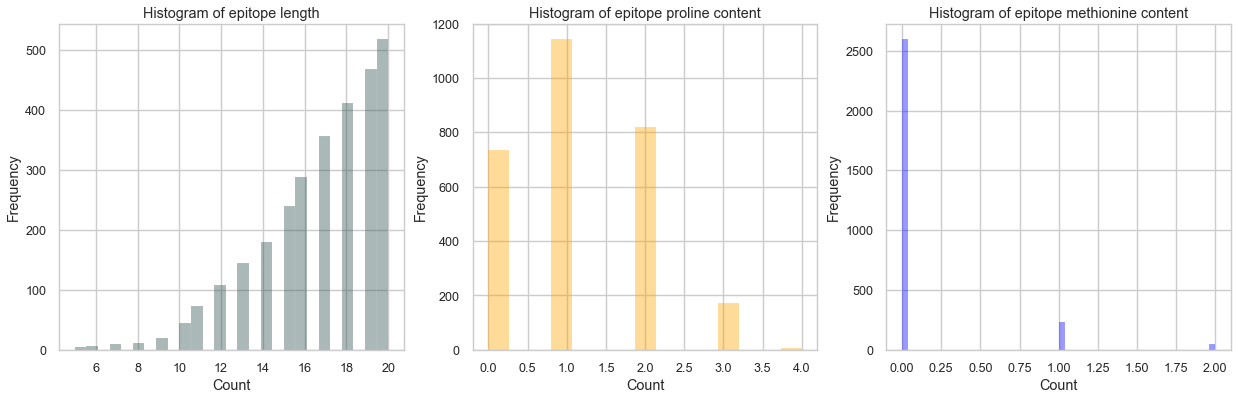

In [38]:
plt.figure(figsize=(21,6))

plt.subplot(131)
sns.distplot(epitope_length, kde=False, color = 'darkslategrey')
plt.title('Histogram of epitope length')
plt.ylabel('Frequency')
plt.xlabel('Count')

plt.subplot(132)
sns.distplot(proline_count, kde=False, color = 'orange')
plt.title('Histogram of epitope proline content')
plt.ylabel('Frequency')
plt.xlabel('Count')

plt.subplot(133)
sns.distplot(methionine_count, kde=False, color = 'blue')
plt.title('Histogram of epitope methionine content')
plt.ylabel('Frequency')
plt.xlabel('Count')

Epitopes of longer length are preferentially predicted to have positive antibody inducing activity than shorter peptide lengths.</br>

But what is the distribution of epitope length in the original COVID data? Let's check that below.

Text(0.5, 1.0, 'Epitope length distribution: COVID data')

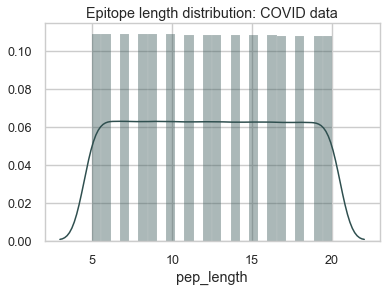

In [40]:
sns.distplot(covid['pep_length'], color = 'darkslategrey')
plt.title('Epitope length distribution: COVID data')

***
# Conclusions
***

**Task 1**</br>
* Additional features including peptide length and within-peptide amino acid count were integrated into the data
* Six different classifiers were trained on the resulting b-cell data 
* When applied to the SARS-CoV dataset, the linear SVC model achieved one of the largest AUC values, showing the highest recall for the positive class
* Note that the model performance was worse for all six classifiers when raw data (i.e. no additional features) were used for training

**Task2**</br>
* A linear SVC model was trained using the b-cell and SARS-CoV data as training data and subsequently applied to the SARS-CoV2 data for epitope predictions
* Epitopes of longer length are preferentially predicted to have positive antibody inducing activity than shorter peptide lengths.
* From 20312 instances, the model predicted a list of 2881 positive epitope predictions
* Of the 2881 epitopes, approximately 75% contained at least one proline molecule
* Only 10% of the predicted epitopes contained a methionine unit, an amino acid that showed relatively low feature importance in Task 1

This work may support early COVID-19 vaccine development based on the predicted epitopes as well as their amino acid content.

Future work may benefit from additional feature generation based on the peptide sequence itself rather than simply amino acid content (e.g. LSTM neural network classification)</br>

In addition, based on the relationships between features and feature importance, steps might be taken to simplify the dataset and reduce dimensionality.